# Interpolation using custom cost matrices


![SegmentLocal](animations/real/emd_interpolation.gif "segment")

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from utils import *

# Interpolation with custom cost matrix

In this notebook we compute interpolations for different cost matrices. Here, we will work with the cost matrix $M$ where:

$$M_{i, j} = d_f(f_1, f_2) * d_a(a_1, a_2)$$

Where $f_i$ are frequencies and $a_i$ are amplitudes of source and target distributions. We will work with the following variations for both $d_f$ and $d_a$:

* Itakuro-Saito distance: $d(x, y) = \frac{x}{y} - log(\frac{x}{y}) - 1$ (infinity if x or y are zero)
* $\chi_2$ distance: $d(x, y) = \frac{(x - y)^2}{x}$ (inifinity if x or y are zero)
* Euclidean distance: $d(x, y) = |x - y|$
* One: $d(x, y) = 1$

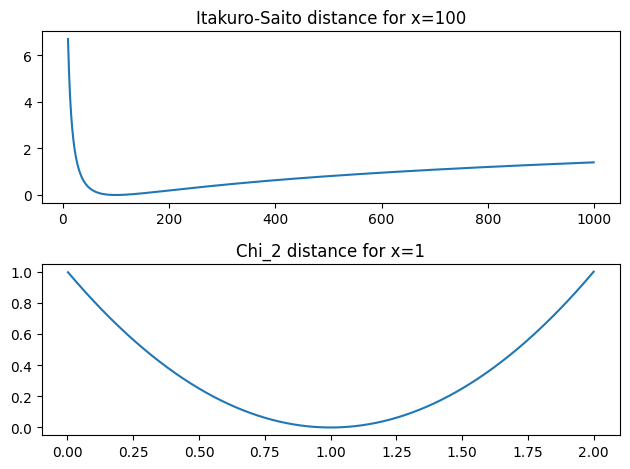

In [2]:
plt.subplot(2, 1, 1)
plt.plot(np.arange(10, 1000), [itakura_saito(100, f) for f in np.arange(10, 1000)])
plt.title('Itakuro-Saito distance for x=100')
plt.subplot(2, 1, 2)
plt.plot(np.linspace(0, 2, 990), [chi_2(1, f) for f in np.linspace(0, 2, 990)])
plt.title('Chi_2 distance for x=1')
plt.tight_layout();

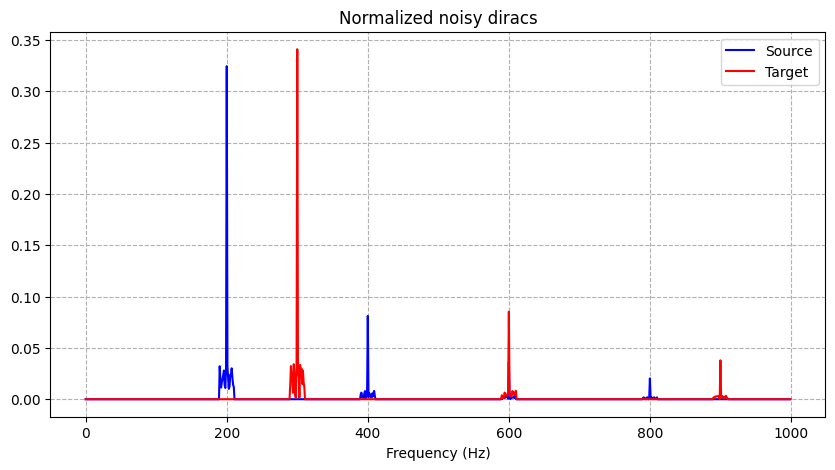

In [3]:
n_samples = 1000

f1 = 200
f2 = 300

def noisy_dirac(frequency, n_samples, width, noise=1e-2, harmonics=True):
    noisy_dirac = np.zeros(n_samples)

    n_harmonics = (n_samples - 1) // frequency
    for i in range(1, n_harmonics + 1):
        noisy_dirac[frequency * i] = 1 / i**2

    for i in range(1, n_harmonics + 1):
        for j in range(1, width + 1):
            noisy_dirac[frequency * i - j] = np.random.random() * noise * noisy_dirac[frequency * i] 
            noisy_dirac[frequency * i + j] = np.random.random() * noise * noisy_dirac[frequency * i]

    return noisy_dirac / np.sum(noisy_dirac)

source = noisy_dirac(f1, n_samples=n_samples, width=10, noise=1e-1)
target = noisy_dirac(f2, n_samples=n_samples, width=10, noise=1e-1)

plt.figure(figsize=(10, 5))
plt.plot(source, label=f'Source', color='blue', linewidth=1.5)
plt.plot(target, label=f'Target', color='red', linewidth=1.5)

plt.xlabel('Frequency (Hz)')
plt.title('Normalized noisy diracs')
plt.grid(True, which="both", ls="--")
plt.legend()

plt.show()

/Users/davidvaldivia/IASD/memoire/audio_ot/audio_1D_transport/utils.py:167: RuntimeWarning: invalid value encountered in scalar multiply
  M[i, j] = freq_dist(support[i], support[j]) * amp_dist(source[i], target[j])


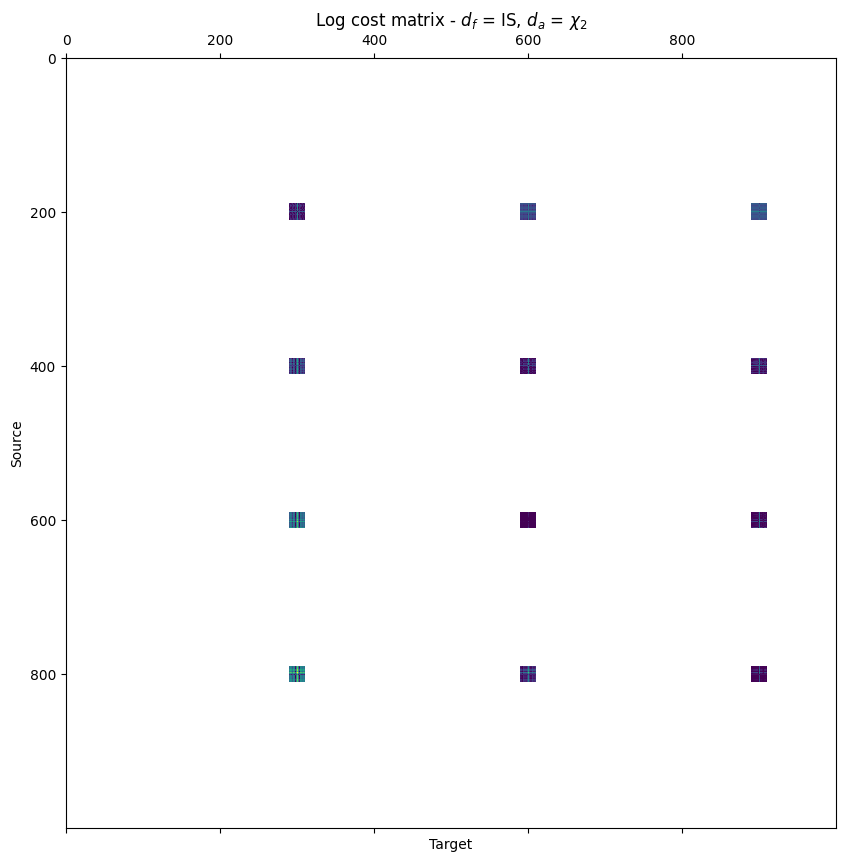

In [4]:
support = np.arange(1, n_samples + 1)

M = cost_matrix(support, source, target, itakura_saito, chi_2)

log_M = np.vectorize(log)(M + 0.0001)
fig, ax = plt.subplots(figsize=(10, 10))

ax.set_title("Log cost matrix - $d_f$ = IS, $d_a$ = $\chi_2$")
ax.set_xlabel("Target", fontsize=10)
ax.set_ylabel("Source", fontsize=10)

cax = ax.matshow(log_M, cmap='viridis')  # Use the colormap of your choice


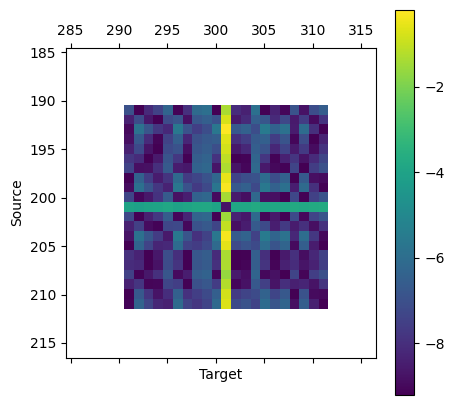

In [5]:
size_submatrix = 16
line_index = 200
col_index = 300

plot_submatrix(log_M, support, size_submatrix, line_index, col_index)

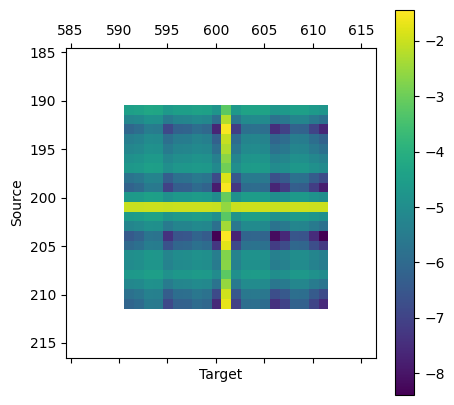

In [6]:
size_submatrix = 16
line_index = 200
col_index = 600

plot_submatrix(log_M, support, size_submatrix, line_index, col_index)

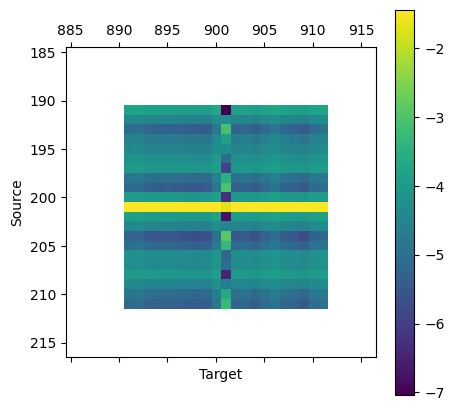

In [7]:
size_submatrix = 16
line_index = 200
col_index = 900

plot_submatrix(log_M, support, size_submatrix, line_index, col_index)

In [13]:
# Optimal transport

alpha = 0.5

# EMD 

dirac_emd_interpolation, dirac_emd_plan = emd_custom_matrix(support, source, target, itakura_saito, chi_2, alpha=alpha)


/Users/davidvaldivia/IASD/memoire/audio_ot/audio_1D_transport/utils.py:167: RuntimeWarning: invalid value encountered in scalar multiply
  M[i, j] = freq_dist(support[i], support[j]) * amp_dist(source[i], target[j])


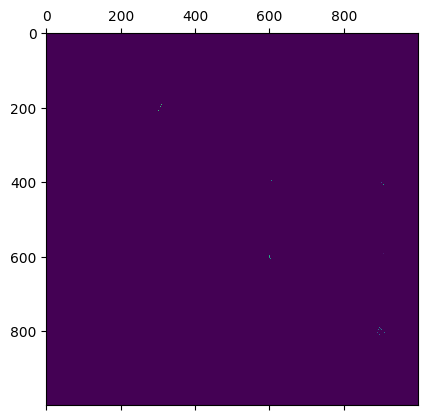

In [14]:
log_plan = np.vectorize(log)(dirac_emd_plan + 1e-5)

plt.matshow(log_plan)

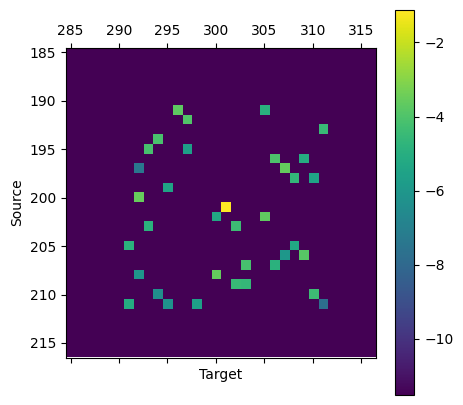

In [15]:
size_submatrix = 16
line_index = 200
col_index = 300

plot_submatrix(log_plan, support, size_submatrix, line_index, col_index)

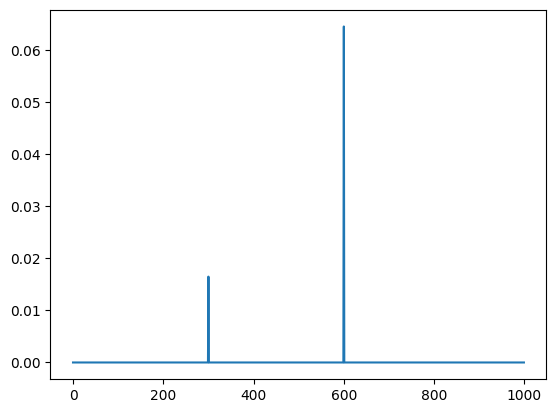

In [16]:
plt.plot(dirac_emd_plan[400])

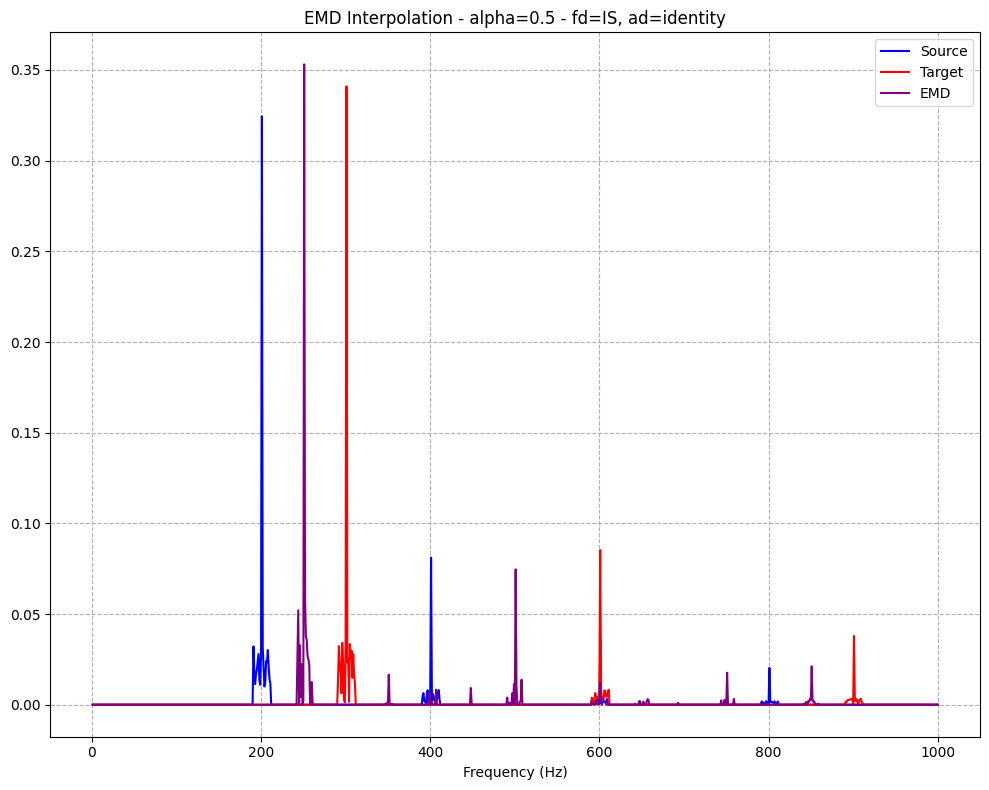

In [17]:
plt.figure(figsize=[10, 8])  # Increase figure size to accommodate both subplots

# Second subplot for A, C, and EMD interpolation
plt.plot(support, source, label=f"Source", color='blue', linewidth=1.5)
plt.plot(support, target, label=f"Target", color='red', linewidth=1.5)
plt.plot(support, dirac_emd_interpolation, label='EMD', color="purple")
plt.xlabel('Frequency (Hz)')
plt.title(f'EMD Interpolation - alpha={alpha} - fd=IS, ad=Chi2')
plt.grid(True, which="both", ls="--")
plt.legend()

plt.tight_layout()  # Adjust the layout so the plots are neatly arranged
plt.show()

In [13]:
import matplotlib.animation as animation

functions = {
    'IS' : itakura_saito,
    'Chi2' : chi_2,
    'euclidean' : euclidean,
    'id' : identity_distance
}

for freq_function_name, freq_function in functions.items():
    for amp_function_name, amp_function in functions.items():

        print(f'frequency function: {freq_function_name}')
        print(f'amp function: {amp_function_name}')

        # Setup figure and axes for the plot
        fig, ax = plt.subplots(figsize=[10, 8])

        # Static plots for A and C
        ax.plot(support, source, label='Source', color='blue', linewidth=1.5)
        ax.plot(support, target, label='Target', color='red', linewidth=1.5)
        ax.set(xlabel='Frequency (Hz)', title=f'EMD interpolation - f:{freq_function_name}, a:{amp_function_name}')
        ax.grid(True, which="both", ls="--")
        ax.legend()

        emd_line, = ax.plot([], [], label='Interpolation', color="purple")

        def update(frame):
            alpha = frame / 5.0  # Assuming 40 frames to go from 0 to 1
            
            interpolation = emd_custom_matrix(support, source, target, freq_function, amp_function, alpha=alpha)

            emd_line.set_data(support, interpolation)
            
            ax.set_title(f'EMD interpolation - f:{freq_function_name}, a:{amp_function_name}, alpha={alpha:.2f}')
            
            return emd_line,

        # Create animation
        ani = animation.FuncAnimation(fig=fig, func=update, frames=np.arange(0, 6), interval=100)

        # Save the animation
        ani.save(f'animations/matrix_exp/{n_samples}_pts/emd_{freq_function_name}_{amp_function_name}.gif')

MovieWriter ffmpeg unavailable; using Pillow instead.


frequency function: IS
amp function: IS


IndexError: list index out of range